In [1]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d qingyuanwang/globalwheatdetectionextend

Dataset URL: https://www.kaggle.com/datasets/qingyuanwang/globalwheatdetectionextend
License(s): CC0-1.0
 97%|███████████████████████████████████████▌ | 843M/873M [00:02<00:00, 307MB/s]
100%|█████████████████████████████████████████| 873M/873M [00:02<00:00, 326MB/s]


In [ ]:
! unzip 'globalwheatdetectionextend.zip'

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torch.cuda.amp import GradScaler, autocast
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
# Load and preprocess the dataset
data = pd.read_csv('train.csv')
bbox = pd.DataFrame(list(data.bbox.apply(lambda x: x[1:-1].split(',')).values), columns=['x1', 'y1', 'w', 'h'])
bbox['x1'] = pd.to_numeric(bbox['x1'])
bbox['y1'] = pd.to_numeric(bbox['y1'])
bbox['w'] = pd.to_numeric(bbox['w'])
bbox['h'] = pd.to_numeric(bbox['h'])
bbox['x2'] = bbox['x1'] + bbox['w']
bbox['y2'] = bbox['y1'] + bbox['h']
bbox.drop(['w', 'h'], inplace=True, axis=1)
bbox['image_id'] = data['image_id']
train_annotations, test_annotations = train_test_split(bbox, test_size=0.1, random_state=21)
print(train_annotations.head())
print(test_annotations.head())

        x1   y1    x2   y2 image_id
63199  150  507   217  571   6092_3
60773   33  358   103  467   6052_1
30948  953  770  1011  837   3162_0
37707    4  671    74  815   4071_0
19413  269    0   329  131   2151_2
        x1   y1   x2    y2 image_id
56794  429   11  501    73   5191_0
363      0  989   47  1023   1012_2
7849   268  677  311   738   1141_5
19842  856  139  931   225   2163_0
47334  570  780  648   851   5031_3


In [6]:
# Create a custom dataset class that loads the images and bounding boxes
class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotations, transform=None):
        self.root = root
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations['image_id'].unique())

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, f"{self.annotations['image_id'].unique()[idx]}.jpg")
        image = Image.open(img_name).convert("RGB")

        # Get all bounding boxes for the current image
        image_boxes = self.annotations[self.annotations['image_id'] == self.annotations['image_id'].unique()[idx]][['x1', 'y1', 'x2', 'y2']].values
        boxes = torch.as_tensor(image_boxes, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # Assuming all objects are of the same class

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transform:
            image = self.transform(image)

        return image, target

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create datasets
train_dataset = WheatDataset(root="train", annotations=train_annotations, transform=transform)
test_dataset = WheatDataset(root="train", annotations=test_annotations, transform=transform)

# Custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
batch_size = 16
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [8]:
# Calculate the number of batches in the training and testing DataLoaders
num_train_batches = len(train_data_loader)
num_test_batches = len(test_data_loader)

print(f"Number of training batches per epoch: {num_train_batches}")
print(f"Number of testing batches per epoch: {num_test_batches}")

Number of training batches per epoch: 88
Number of testing batches per epoch: 87


In [9]:
# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 class (wheat) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Determine number of epochs
num_epochs = 15

In [11]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (images, targets) in enumerate(train_data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")

Epoch 1/15, Loss: 0.8744080066680908
Epoch 2/15, Loss: 0.8515942096710205
Epoch 3/15, Loss: 0.792666494846344
Epoch 4/15, Loss: 0.8278788924217224
Epoch 5/15, Loss: 0.8072844743728638
Epoch 6/15, Loss: 0.8162654638290405
Epoch 7/15, Loss: 0.7265045046806335
Epoch 8/15, Loss: 0.7972881197929382
Epoch 9/15, Loss: 0.7472774982452393
Epoch 10/15, Loss: 0.7223047018051147
Epoch 11/15, Loss: 0.7274865508079529
Epoch 12/15, Loss: 0.733259916305542
Epoch 13/15, Loss: 0.6995492577552795
Epoch 14/15, Loss: 0.6627753973007202
Epoch 15/15, Loss: 0.6780757904052734


# Evaluate model

In [12]:
def calculate_iou(box1, box2):
    # Calculate coordinates of intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate area of intersection rectangle
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou
    

# Set the model to evaluation mode
model.eval()

# Initialize variables to store evaluation metrics
total_correct = 0
total_predictions = 0
total_iou = 0.0

# Disable gradient calculation
with torch.no_grad():
    for images, targets in test_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Get predictions
        predictions = model(images)

        # Iterate over each image and its corresponding predictions and targets
        for pred, target in zip(predictions, targets):
            pred_boxes = pred['boxes'].cpu().numpy()
            pred_scores = pred['scores'].cpu().numpy()
            gt_boxes = target['boxes'].cpu().numpy()

            # Calculate IoU for each prediction box with each ground truth box
            for pred_box in pred_boxes:
                max_iou = 0.0
                for gt_box in gt_boxes:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > max_iou:
                        max_iou = iou

                total_iou += max_iou
                total_predictions += 1

                # Consider a prediction correct if IoU > 0.5
                if max_iou > 0.5:
                    total_correct += 1

# Calculate average IoU and accuracy
average_iou = total_iou / total_predictions if total_predictions > 0 else 0.0
accuracy = total_correct / total_predictions if total_predictions > 0 else 0.0

print(f"Average IoU: {average_iou:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Average IoU: 0.0714
Accuracy: 0.0844


# Test on a Sample from the Test Loader

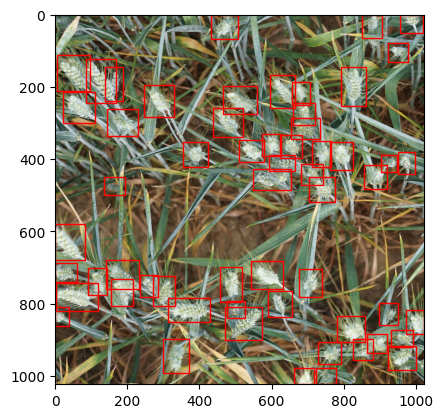

In [13]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Take a sample from the test data loader
    images, targets = next(iter(test_data_loader))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Get predictions
    predictions = model(images)

# Function to visualize the image with predicted bounding boxes
def visualize_predictions(image, predictions):
    # Convert image to numpy array and transpose to (H, W, C) format
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = (image * 255).astype(np.uint8)  # Convert to 8-bit image

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Iterate over predictions and draw bounding boxes
    for pred in predictions:
        boxes = pred['boxes'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()

        for box, score in zip(boxes, scores):
            if score > 0.5:  # Only draw boxes with confidence score > 0.5
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.show()

# Visualize the first image in the batch with its predicted bounding boxes
visualize_predictions(images[0], [predictions[0]])

# Save the model

In [14]:
torch.save(model.state_dict(), 'wheat_detection_model.pth')